# Dipole
This example reproduces the topology constraint.

In [1]:
import os
# os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
from quadcoil import quadcoil, tree_len

from simsopt.mhd import Vmec
from simsopt import load
from simsopt.field import CurrentPotentialFourier, CurrentPotentialSolve
import jax
import os
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import block_until_ready, devices, config
import time
devices()

[CudaDevice(id=0), CudaDevice(id=1)]

## Loading files

In [2]:
# Loading muse++ equilibrium into VMEC
# filename_pp = "wout_muse++.nc"
# equil_pp = Vmec(filename_pp, keep_all_files=True)
# plasma_surface = equil_pp.boundary
# net_poloidal_current_amperes = equil_pp.external_current()

# Loading NCSX. Seems to work.
# filename_pp = "NCSX"
# winding_surface, plasma_surface = load('surfaces.json')
# net_poloidal_current_amperes = 11884578.094260072
# mpol = 4
# ntor = 4
# jax.config.update('jax_enable_x64', True)

# Loading L-P. Doesn't work well n single-stage. 
# is it a tuning issue?
filename_pp = 'wout_LandremanPaul2021_QA_lowres'
equil_pp = Vmec(filename_pp + '.nc', keep_all_files=True)
plasma_surface = equil_pp.boundary
net_poloidal_current_amperes = equil_pp.external_current()


# Problem settings

In [3]:
# Settings 
separation = plasma_surface.minor_radius() # 0.1
mpol = 12
ntor = 12
nfp = plasma_surface.nfp
plasma_M_theta = 16
plasma_N_phi = 32

## Running a REGCOIL scan

In [4]:
if not os.path.exists('regcoil_' + filename_pp + '.npy'):
    # We scan the REGCOIL regularization factor and recover the 
    # dipole distribution Caoxiang's paper chose
    f_B_test_list = []
    phi_test_list = []
    f_K_test_list = []
    time_quadcoil_list = []
    time_regcoil_list = []
    phi_ans_list = []
    f_B_ans_list = []
    f_K_ans_list = []
    for i in jnp.append(10**np.linspace(-10, -20, 20), 0.):
        # Run QUADCOIL first
        time1 = time.time()
        regcoili_out_dict, regcoili_qp, regcoil1_dofs, status = quadcoil(
            nfp=plasma_surface.nfp,
            stellsym=plasma_surface.stellsym,
            mpol=mpol,
            ntor=ntor,
            plasma_dofs=plasma_surface.get_dofs(),
            plasma_mpol=plasma_surface.mpol,
            plasma_ntor=plasma_surface.ntor,
            net_poloidal_current_amperes=net_poloidal_current_amperes,
            net_toroidal_current_amperes=0.,
            plasma_coil_distance=separation,
            objective_name=('f_B', 'f_K'),
            objective_weight=np.array([1., i]),
            objective_unit=(1., 1.),
            metric_name=('f_B', 'f_K'),
        )
    
        phi_test_list.append(regcoil1_dofs)
        f_B_test_list.append(regcoili_out_dict['f_B']['value'])
        f_K_test_list.append(regcoili_out_dict['f_K']['value'])
        time2 = time.time()
        time_quadcoil_list.append(time2-time1)
        print('i =', i, '| time =', time2-time1)
    
        wsi = regcoili_qp.winding_surface.to_simsopt()
        psi = regcoili_qp.plasma_surface.to_simsopt()
        cpi = CurrentPotentialFourier(
            wsi, mpol=mpol, ntor=ntor,
            net_poloidal_current_amperes=net_poloidal_current_amperes,
            net_toroidal_current_amperes=0.,
            stellsym=True)
        cpsti = CurrentPotentialSolve(cpi, psi, 0)
        regcoil1_dofs_ans, regcoili_f_B_ans, regcoili_f_K_ans = cpsti.solve_tikhonov(i)
        time2 = time.time()
        time_regcoil_list.append(time2-time1)
        phi_ans_list.append(regcoil1_dofs_ans)
        f_B_ans_list.append(regcoili_f_B_ans)
        f_K_ans_list.append(regcoili_f_K_ans)
        
    print('QUADCOIL avg time:', np.average(time_quadcoil_list), '(s)')
    print('QUADCOIL max time:', np.max(time_quadcoil_list), '(s)')
    print('REGCOIL avg time:', np.average(time_regcoil_list), '(s)')
    print('REGCOIL max time:', np.max(time_regcoil_list), '(s)')
    time_regcoil_list = np.array(time_regcoil_list)
    phi_ans_list = np.array(phi_ans_list)
    f_B_ans_list = np.array(f_B_ans_list)
    f_K_ans_list = np.array(f_K_ans_list)
    time_quadcoil_list = np.array(time_quadcoil_list)
    phi_test_list = np.array(phi_test_list)
    f_B_test_list = np.array(f_B_test_list)
    f_K_test_list = np.array(f_K_test_list)
    jnp.save('regcoil_' + filename_pp + '.npy',{
        'regcoili_qp': regcoili_qp,
        'time_regcoil_list': time_regcoil_list,
        'phi_ans_list': phi_ans_list,
        'f_B_ans_list': f_B_ans_list,
        'f_K_ans_list': f_K_ans_list,
        'time_quadcoil_list': time_quadcoil_list,
        'phi_test_list': phi_test_list,
        'f_B_test_list': f_B_test_list,
        'f_K_test_list': f_K_test_list,
    })
    # Is quadcoil really well-behaved than regcoil?
    print('Quadcoil seems to be more well-behaved than regcoil.')    
else:
    dict = jnp.load('regcoil_' + filename_pp + '.npy', allow_pickle=True).item()
    regcoili_qp = dict['regcoili_qp']
    time_regcoil_list = dict['time_regcoil_list']
    phi_ans_list = dict['phi_ans_list']
    f_B_ans_list = dict['f_B_ans_list']
    f_K_ans_list = dict['f_K_ans_list']
    time_quadcoil_list = dict['time_quadcoil_list']
    phi_test_list = dict['phi_test_list']
    f_B_test_list = dict['f_B_test_list']
    f_K_test_list = dict['f_K_test_list']

f_K at the inflection point: 6901532000000.0
f_B at the inflection point: 9.9165816e-05


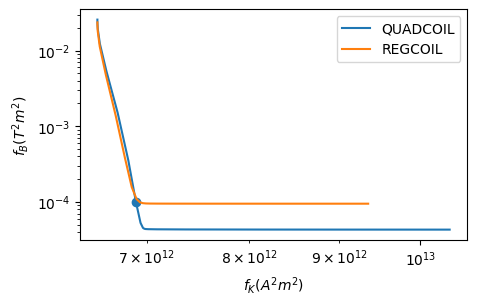

In [5]:
# inflection point
i_infl = 10 # 12 doesn't work # np.argmin(f_K_test_list * f_B_test_list)
plt.figure(figsize=(5,3))
plt.plot(f_K_test_list, f_B_test_list, label='QUADCOIL')
plt.plot(f_K_ans_list, f_B_ans_list, label='REGCOIL')
plt.ylabel('$f_B(T^2m^2)$')
plt.xlabel('$f_K(A^2m^2)$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.scatter(f_K_test_list[i_infl], f_B_test_list[i_infl])
print('f_K at the inflection point:', f_K_test_list[i_infl])
print('f_B at the inflection point:', f_B_test_list[i_infl])
f_B_target = f_B_test_list[i_infl]
phi_regcoil = phi_test_list[i_infl]

In [6]:
# Calculating normalization factors
from quadcoil.quantity import f_max_Phi2, f_B, f_max_Phi, Phi, f_l1_Phi, f_max_Phi4, Phi
# Auto-normalization will not work for dipole objectives,
# because they are zero when Phi is 0.
# Therefore, we choose instead to normalize
# using the Phi measured from the inflection point.
unit_Phi2 = f_max_Phi2(regcoili_qp, phi_test_list[i_infl])
print('Max(Phi^2) =', unit_Phi2, 'At the inflection point.')
unit_Phi4 = f_max_Phi4(regcoili_qp, phi_test_list[i_infl])
print('Max(Phi^4) =', unit_Phi4, 'At the inflection point.')
unit_Phi = f_max_Phi(regcoili_qp, phi_test_list[i_infl])
print('Max(Phi) =', unit_Phi, 'At the inflection point.')
# unit_l1 = f_l1_Phi(regcoili_qp, phi_test_list[i_infl])
# print('||Phi||1) =', unit_l1, 'At the inflection point.')

Max(Phi^2) = 99414410000.0 At the inflection point.
Max(Phi^4) = 9.883225e+21 At the inflection point.
Max(Phi) = 315300.5 At the inflection point.



## Taylor test for dipole thickness optimization

In [32]:
outdict_list = []
plasma_dof_0_list = []
time_quadcoil_list = []
time_regcoil_list = []
lam_list = []
mu_list = []
c_list = []
qp_list = []
dof_test_list = []
test_i = 1
for i in jnp.linspace(-0.05, 0.05, 40):
    plasma_dof_i = plasma_surface.get_dofs().copy()
    plasma_dof_i[test_i] *= (1 + i)
    # Run QUADCOIL first
    time1 = time.time()
    out_dict_i, qp_i, dofs_i, status_i = quadcoil(
        nfp=plasma_surface.nfp,
        stellsym=plasma_surface.stellsym,
        plasma_coil_distance=separation,
        mpol=mpol,
        ntor=ntor,
        plasma_dofs=plasma_dof_i,
        plasma_mpol=plasma_surface.mpol,
        plasma_ntor=plasma_surface.ntor,
        net_poloidal_current_amperes=net_poloidal_current_amperes,
        net_toroidal_current_amperes=0.,
        metric_name=('f_max_Phi', 'f_K', 'f_B'),
        objective_name='f_max_Phi', # Minimizing peak dipole density
        objective_unit=unit_Phi, # under an f_B constraint
        constraint_name=('f_B',),
        constraint_type=('<=',),
        constraint_unit=(f_B_target,),
        constraint_value=np.array([f_B_target,]),
        # xstop_inner=1e-6,
        # fstop_inner=0.,
        verbose=1,
        # **numerical_kwargs
    )
    qp_list.append(qp_i)
    print('f_B!!!!!!!', f_B(qp_i, dofs_i))
    block_until_ready(dofs_i)
    block_until_ready(out_dict_i)
    block_until_ready(qp_i)
    time2 = time.time()
    time_quadcoil_list.append(time2-time1)
    print('time:', time2-time1)
    # REGCOIL ---------------------------------------------------
    plasma_dof_0_list.append(plasma_dof_i[test_i])
    outdict_list.append(out_dict_i)
    dof_test_list.append(dofs_i)
    lam_list.append(status_i['inner_fin_lam'])
    mu_list.append(status_i['inner_fin_mu'])
    c_list.append(status_i['inner_fin_c'])
print('QUADCOIL avg time:', np.average(time_quadcoil_list), '(s)')
print('QUADCOIL max time:', np.max(time_quadcoil_list), '(s)')

Running QUADCOIL in verbose mode 

----- Input summary ----- 
Evaluation phi quadpoint num: 32
Evaluation theta quadpoint num: 34
Plasma phi quadpoint num: 32
Plasma theta quadpoint num: 34
Winding phi quadpoint num: 64
Winding theta quadpoint num: 34
Net poloidal current (A): 5348235.954266963
Net toroidal current (A): 0.0
Constraint names: ('f_B',)
Constraint types: ('<=',)
Constraint units: (Array(9.9165816e-05, dtype=float32),)
Constraint values: [9.9165816e-05]
Objective names: f_max_Phi
Objective units: 315300.5
Objective weights: 1.0
Numerical parameters:
    c_init: 1.0
    c_growth_rate: 2
    xstop_outer: 1e-08
    ctol_outer: 1e-08
    fstop_inner: 1e-08
    xstop_inner: 1e-08
    gtol_inner: 1e-08
    maxiter_tot: 10000
    maxiter_inner: 1000
Plasma-coil distance (m): 0.16831206437162433
----- DOF summary ----- 
After converting non-smooth terms (such as |f|) into
smooth terms, auxiliary vars and constraints, the dofs are:
    phi_scaled: (312,)
    scaled_max_phi: (1,)
To

In [33]:
stacked_outdict = jax.tree_util.tree_map(lambda *xs: jnp.stack(xs, axis=0), *outdict_list)
stacked_dofs = jax.tree_util.tree_map(lambda *xs: jnp.stack(xs, axis=0), *dof_test_list)

In [34]:
stacked_outdict['f_B'].keys()

dict_keys(['Ohess_cond', 'Ohess_err', 'Ohess_err2', 'Ohess_err_norm', 'Ohess_err_norm2', 'Ohess_rank', 'dfdy1', 'dfdy2', 'grad', 'grada', 'gradb', 'gradc', 'hess_cond', 'hess_err', 'hess_err2', 'hess_err_norm', 'hess_err_norm2', 'hess_rank', 'value', 'vihp_raw'])

In [56]:
def plot_stack_normalized(arr):
    # Axis 1 is case id
    # axis 2 is dof label
    for i_plot in range(arr.shape[1]):
        norm = jnp.where(arr[0, i_plot]!=0, 1/jnp.average(jnp.abs(arr[:, i_plot])), 1)
        plt.plot(plasma_dof_0_list, arr[:, i_plot]*norm)

Text(0, 0.5, '$\\Phi_{max}$')

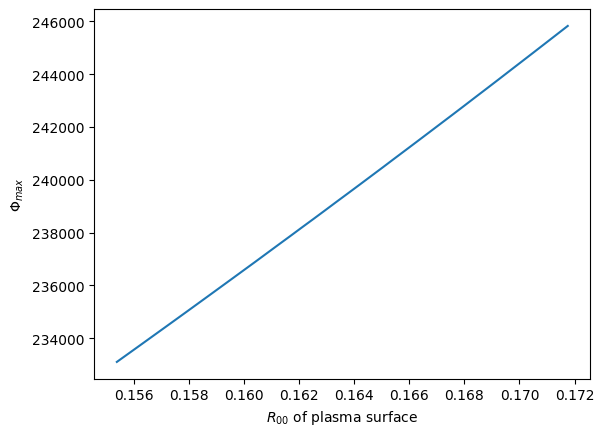

In [53]:
# The objective is smooth, meaning the solver converged well, but 
# the derivative is not working well. This has a few reasons.
plt.plot(plasma_dof_0_list, stacked_outdict['f_max_Phi']['value'])
plt.xlabel('$R_{00}$ of plasma surface')
plt.ylabel(r'$\Phi_{max}$')

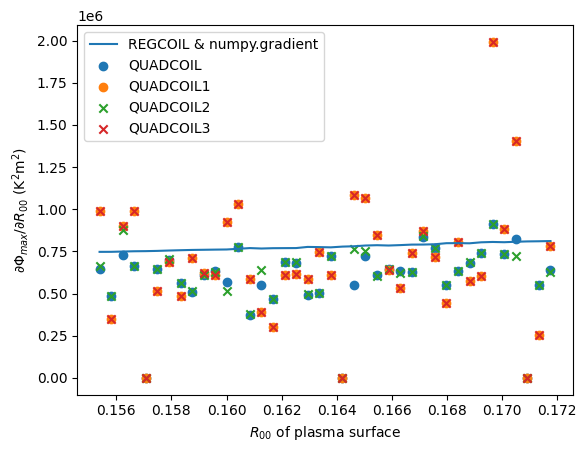

In [54]:
# Even using lstsq the actual derivative values don't change much
grad_f_max_Phi = jnp.gradient(stacked_outdict['f_max_Phi']['value'], plasma_dof_0_list[1]-plasma_dof_0_list[0])
plt.plot(plasma_dof_0_list, grad_f_max_Phi, label='REGCOIL & numpy.gradient')
plt.scatter(plasma_dof_0_list, stacked_outdict['f_max_Phi']['grad']['df_dplasma_dofs'][:, test_i], label='QUADCOIL')
plt.scatter(plasma_dof_0_list, stacked_outdict['f_max_Phi']['grada']['df_dplasma_dofs'][:, test_i], label='QUADCOIL1')
plt.scatter(plasma_dof_0_list, stacked_outdict['f_max_Phi']['gradb']['df_dplasma_dofs'][:, test_i], label='QUADCOIL2', marker='x')
plt.scatter(plasma_dof_0_list, stacked_outdict['f_max_Phi']['gradc']['df_dplasma_dofs'][:, test_i], label='QUADCOIL3', marker='x')
# plt.plot(plasma_dof_0_list, f_max_Phi_diff_test_list2, label='QUADCOIL2', linestyle='dashed')
plt.xlabel('$R_{00}$ of plasma surface')
plt.ylabel(r'$\partial \Phi_{max}/\partial R_{00}$ (K$^2$m$^2$)')
# plt.ylim(jnp.min(grad_f_max_Phi), jnp.max(grad_f_max_Phi))
plt.legend()

Text(0, 0.5, '$\\Phi$ harmonics')

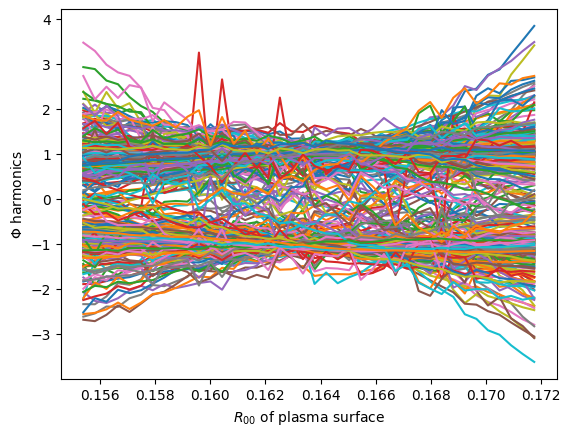

In [57]:
# Issue0: ill-posedness. Even when the objective is 
# smooth, the dofs and other quantities aren't as plasma
# properties change. 
# Max dipole seems much less ill-posed than topology? 
# This makes sense.
plot_stack_normalized(stacked_dofs['phi'])
plt.xlabel('$R_{00}$ of plasma surface')
plt.ylabel(r'$\Phi$ harmonics')

Text(0, 0.5, 'VIHP linear solve error')

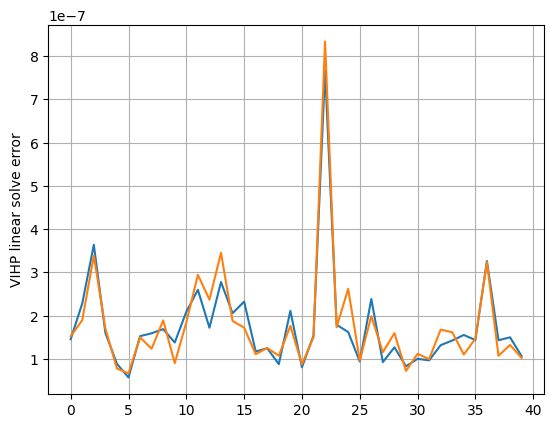

In [44]:
# Inverses seem accurate, but we probably should not trust this, 
# Not sure if we're at a stationary point
plt.plot(stacked_outdict['f_max_Phi']['hess_err_norm'])
plt.plot(stacked_outdict['f_K']['hess_err_norm'])
plt.grid()
plt.ylabel('VIHP linear solve error')

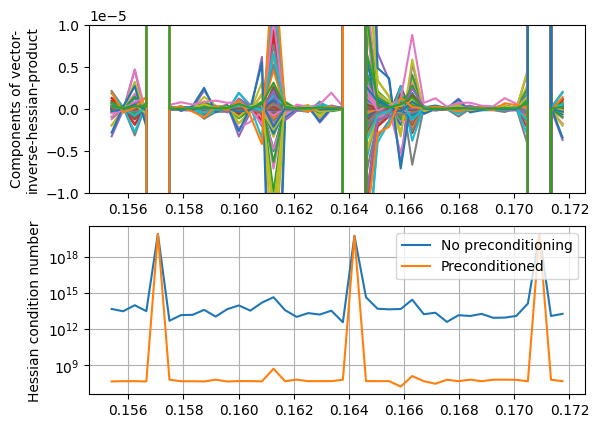

In [64]:
# Issue 1: why do vihp vary this dramatically?
# Despite the low linear-solve error, vihp is very bumpy.
# This probably means we can't trust the Hessian inverse.
# This is substantiated by the agreements between the location
# of ill-conditioning with where VIHP blows up.
plt.subplot(2,1,1)
plot_stack_normalized(stacked_outdict['f_max_Phi']['vihp_raw'])
plt.ylim(-1e-5, 1e-5)
plt.ylabel('Components of vector-\ninverse-hessian-product')
plt.subplot(2,1,2)
plt.plot(plasma_dof_0_list, stacked_outdict['f_max_Phi']['hess_cond'], label='No preconditioning')
plt.plot(plasma_dof_0_list, stacked_outdict['f_max_Phi']['Ohess_cond'], label='Preconditioned')
plt.grid()
plt.legend()
plt.ylabel('Hessian condition number')
plt.yscale('log')

Text(0, 0.5, 'Normalized multiplier $\\mu$. Non-zero $\\mu \\Leftrightarrow$ active constraints. ')

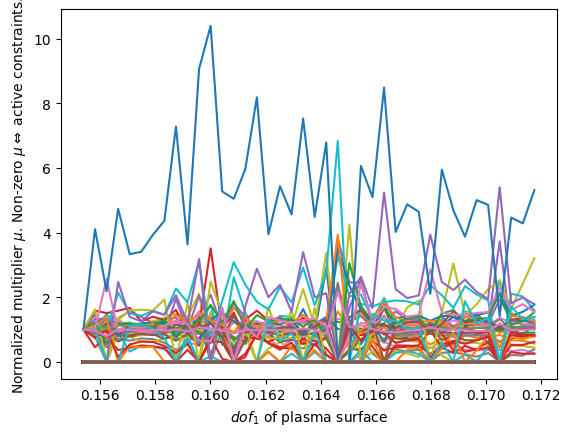

In [40]:
# Issue 2. The auglag objective may be losing constraint information
# because even constraints known to be active at the optimum occasionally
# becomes inactive when they're sufficiently satisfied. Because of this 
# L_k may lose derivative information.
plot_stack_normalized(jnp.array(mu_list))
plt.ylabel(r'Normalized multiplier $\mu$. Non-zero $\mu \Leftrightarrow$ active constraints. ')

Text(0, 0.5, 'Normalized multiplier $\\mu_{f_B}$. Non-zero $\\mu \\Leftrightarrow$ active. ')

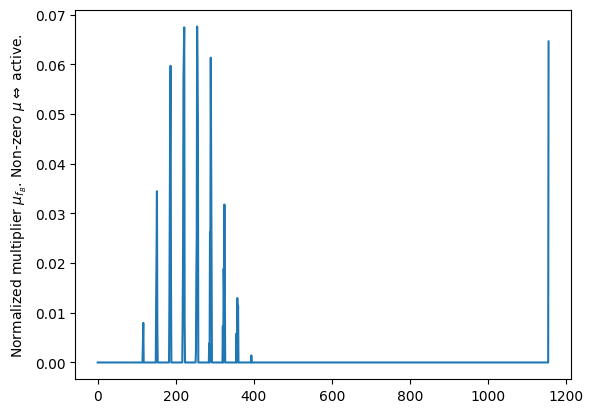

In [42]:
# This is the multiplier of the f_B constraint. Because all other constraints
# are introduced to enforce this, we know is has to be active at the optimum.
# yet it is inactive in most cases during the sweep.
plt.plot(jnp.array(mu_list)[-1])
plt.ylabel(r'Normalized multiplier $\mu_{f_B}$. Non-zero $\mu \Leftrightarrow$ active. ')

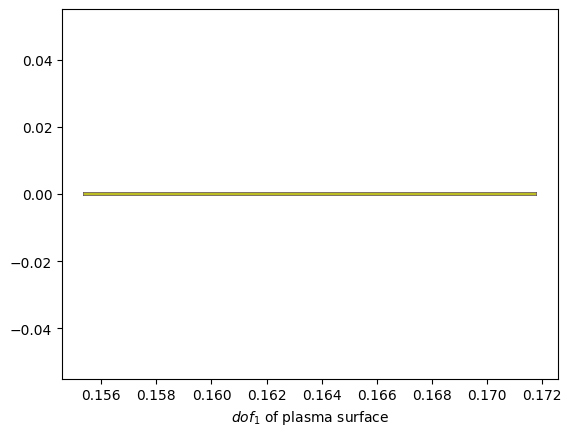

In [13]:
# Issue 3: why is f_max_Phi's y derivative zero?
plot_stack_normalized(stacked_outdict['f_max_Phi']['dfdy2'])

In [14]:
time_quadcoil_list = jnp.array(time_quadcoil_list)
time_regcoil_list = jnp.array(time_regcoil_list)
plasma_dof_0_list = jnp.array(plasma_dof_0_list)

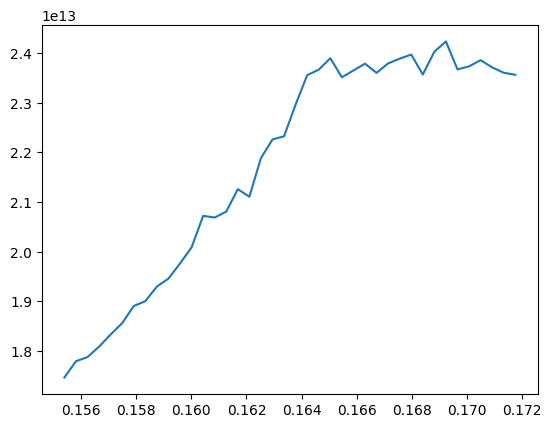

In [16]:
plt.plot(plasma_dof_0_list, stacked_outdict['f_K']['value'])

The inaccuracy doesn't come from solver. It also can't be addressed by our current pre-conditioner.

In [17]:
stacked_outdict['f_max_Phi'].keys()

dict_keys(['Ohess_cond', 'Ohess_err', 'Ohess_err2', 'Ohess_err_norm', 'Ohess_err_norm2', 'Ohess_rank', 'dfdy1', 'dfdy2', 'grad', 'grada', 'gradb', 'gradc', 'hess_cond', 'hess_err', 'hess_err2', 'hess_err_norm', 'hess_err_norm2', 'hess_rank', 'value', 'vihp_raw'])

In [ ]:
jnp.save('breaking_params2', {
    'nfp': plasma_surface.nfp,
    'stellsym': plasma_surface.stellsym,
    'plasma_coil_distance': separation,
    'mpol': mpol,
    'ntor': ntor,
    'plasma_dofs': plasma_dof_i,
    'plasma_mpol': plasma_surface.mpol,
    'plasma_ntor': plasma_surface.ntor,
    'net_poloidal_current_amperes': net_poloidal_current_amperes,
    'net_toroidal_current_amperes': 0.,
    'metric_name': ('f_max_Phi', 'f_K', 'f_B'),
    'objective_name': 'f_max_Phi2', # Minimizing peak dipole density
    'objective_unit': unit_Phi2, # under an f_B constraint
    'constraint_name': ('f_B',),
    'constraint_type': ('<=',),
    'constraint_unit': (f_B_target,),
    'constraint_value': np.array([f_B_target,]),
    'verbose': 1
})

## Dipole layer thickness optimization
Here, we constrain the field error, and target the maximum 
magnitude of the dipole density over the surface

In [ ]:
# Note
# quadcoil seems only tned to the one test case. 
# Using initial state doesn't seem to help. 
# Phi scaling doesn't seem to help either.
# The first iter did not converge. This doesn't seem essential tho
# Is it outer convergence tolerance that causes low constraint satisfaction?

time1=time.time()
# Solving with the quadcoil default function
out_dict, qp, dofs, status = quadcoil(
    nfp=plasma_surface.nfp,
    stellsym=plasma_surface.stellsym,
    plasma_coil_distance=separation,
    mpol=mpol,
    ntor=ntor,
    plasma_dofs=plasma_surface.get_dofs(),
    plasma_mpol=plasma_surface.mpol,
    plasma_ntor=plasma_surface.ntor,
    net_poloidal_current_amperes=net_poloidal_current_amperes,
    net_toroidal_current_amperes=0.,
    metric_name='f_max_Phi',
    # phi_init=phi_test_list[i_infl]['phi'],
    phi_unit = jnp.max(jnp.abs(phi_test_list[i_infl]['phi'])),
    objective_name='f_max_Phi2', # Minimizing peak dipole density
    objective_unit=unit_Phi2, # under an f_B constraint
    constraint_name=('f_B',),
    constraint_type=('<=',),
    constraint_unit=(f_B_target,),
    constraint_value=np.array([f_B_target,]),
    maxiter_tot = 20000,
    maxiter_inner = 1000,
    fstop_inner=1e-8,
    # value_only=True,
    verbose=3,
)
jax.block_until_ready(dofs)
time2=time.time()
print('time:', time2-time1)# Run your function

In [ ]:
dofs_regcoil = phi_test_list[i_infl]
print('f_B from REGCOIL:      ', f_B(regcoili_qp, dofs_regcoil))
print('f_B from QUADCOIL:     ', f_B(qp, dofs))
f_Phi_ctrl = f_max_Phi(regcoili_qp,dofs_regcoil)
f_Phi_1 = f_max_Phi(qp, dofs)
print('Max dipole dens from REGCOIL:      ', f_Phi_ctrl)
print('Max dipole dens from QUADCOIL:     ', f_Phi_1, round((f_Phi_ctrl-f_Phi_1)/f_Phi_ctrl*100, 3), '% improvement')

phi_regcoil = Phi(qp, dofs_regcoil)
phi_quadcoil = Phi(qp, dofs)
cmin = np.min([phi_regcoil, phi_quadcoil])
cmax = np.max([phi_regcoil, phi_quadcoil])

fig, axes = plt.subplots(1, 2, figsize=(6, 3), constrained_layout=True)

# Plot for REGCOIL
im0 = axes[0].contour(phi_regcoil, vmin=cmin, vmax=cmax, cmap = 'seismic', levels=20)
axes[0].set_title(r'REGCOIL\n$\Phi_{max}$='+str(int(f_Phi_ctrl))+'A')

# Plot for QUADCOIL
im1 = axes[1].contour(phi_quadcoil, vmin=cmin, vmax=cmax, cmap = 'seismic', levels=20)
axes[1].set_title(r'QUADCOIL\n$\Phi_{max}$='+str(int(f_Phi_1))+'A')



# Add colorbar with better positioning
cbar = fig.colorbar(im1, ax=axes, orientation='vertical', shrink=1., aspect=25, pad=0.05)
cbar.set_label("Dipole Density (A)")

plt.show()


## Dipole sparsity optimization
Here, we constrain the field error and maximum dipole density, 
and target the L-1 norm of the dipole over the surface.

In [ ]:
f_Phi_ctrl = f_max_Phi(regcoili_qp, phi_test_list[i_infl])

In [ ]:
# Solving with the quadcoil default function
time1 = time.time()
l1_out_dict, l1_qp, l1_dofs, l1_status = quadcoil(
    nfp=plasma_surface.nfp,
    stellsym=plasma_surface.stellsym,
    plasma_coil_distance=separation,
    mpol=mpol,
    ntor=ntor,
    plasma_dofs=plasma_surface.get_dofs(),
    plasma_mpol=plasma_surface.mpol,
    plasma_ntor=plasma_surface.ntor,
    net_poloidal_current_amperes=net_poloidal_current_amperes,
    net_toroidal_current_amperes=0.,
    metric_name='f_B',
    objective_name='f_l1_Phi', # Minimizing the L1 norm of Phi
    objective_unit=unit_l1, # under an f_B, max Phi constraint
    constraint_name=('f_B', 'f_max_Phi',),
    constraint_type=('<=', '<=',),
    constraint_unit=(f_B_target, f_Phi_ctrl,),
    constraint_value=np.array([f_B_target, f_Phi_ctrl,]),
    value_only=True
    # verbose=3,
    # **numerical_kwargs
)
time2 = time.time()
print(time2-time1)

In [ ]:
print('f_B from REGCOIL:      ', f_B(regcoili_qp, phi_test_list[i_infl]))
print('f_B from QUADCOIL:     ', f_B(l1_qp, l1_dofs))
f_l1_Phi_crtl = f_l1_Phi(regcoili_qp, phi_test_list[i_infl])
f_l1_Phi_l1 = f_l1_Phi(l1_qp, l1_dofs)
print('Max L1-norm from REGCOIL:      ', f_l1_Phi_crtl)
print('Max L1-norm from QUADCOIL:     ', f_l1_Phi_l1, round((f_l1_Phi_crtl-f_l1_Phi_l1)/f_l1_Phi_crtl*100, 3), '% improvement')

phi_regcoil = Phi(regcoili_qp, phi_test_list[i_infl])
phi_quadcoil_l1 = Phi(l1_qp, l1_dofs)
cmin = np.min([phi_regcoil, phi_quadcoil_l1])
cmax = np.max([phi_regcoil, phi_quadcoil_l1])

fig, axes = plt.subplots(1, 2, figsize=(6, 3), constrained_layout=True)

# Plot for REGCOIL
im0 = axes[0].contour(phi_regcoil, vmin=cmin, vmax=cmax, cmap = 'seismic', levels=20)
axes[0].set_title('REGCOIL')

# Plot for QUADCOIL
im1 = axes[1].contour(phi_quadcoil_l1, vmin=cmin, vmax=cmax, cmap = 'seismic', levels=20)
axes[1].set_title('QUADCOIL')



# Add colorbar with better positioning
cbar = fig.colorbar(im1, ax=axes, orientation='vertical', shrink=1., aspect=25, pad=0.05)
cbar.set_label("Dipole Density (A)")

plt.show()


### Cumulative distribution function plot
This plot shows the proportion of grid points 
with dipole density $\leq x\% \Phi_{max}$.

In [ ]:

# Flatten arrays
phi_reg = jnp.abs(phi_regcoil.flatten())
phi_quad = jnp.abs(phi_quadcoil_l1.flatten())

# Sort values
phi_reg_sorted = np.sort(phi_reg) / np.max(phi_reg) * 100
phi_quad_sorted = np.sort(phi_quad) / np.max(phi_reg) *100

# Compute CCDFs
ccdf_reg = np.arange(1, len(phi_reg_sorted)+1) / len(phi_reg_sorted)*100
ccdf_quad = np.arange(1, len(phi_quad_sorted)+1) / len(phi_quad_sorted)*100

# Plot
plt.figure(figsize=(5, 3))
plt.plot(phi_reg_sorted, ccdf_reg, label='REGCOIL', color='blue')
plt.plot(phi_quad_sorted, ccdf_quad, label='QUADCOIL', color='orange')
plt.xticks(np.linspace(0, 100, 11))
# Labels and legend
plt.xlabel('Dipole density, as % of $\Phi_{max}$ (A)')
plt.ylabel('CDF (% $\leq$ x)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
i = jnp.linspace(-0.1, 0.1, 50)[0]
plasma_dof_i = plasma_surface.get_dofs().copy()
plasma_dof_i[0] *= (1 + i)
out_dict_i, qp_i, dofs_i, status_i = quadcoil(
    nfp=plasma_surface.nfp,
    stellsym=plasma_surface.stellsym,
    plasma_coil_distance=separation,
    mpol=mpol,
    ntor=ntor,
    plasma_dofs=plasma_dof_i,
    plasma_mpol=plasma_surface.mpol,
    plasma_ntor=plasma_surface.ntor,
    net_poloidal_current_amperes=net_poloidal_current_amperes,
    net_toroidal_current_amperes=0.,
    metric_name=('f_max_Phi', 'f_K', 'f_B'),
    objective_name='f_max_Phi', # Minimizing peak dipole density
    objective_unit=unit_Phi, # under an f_B constraint
    constraint_name=('f_B',),
    constraint_type=('<=',),
    constraint_unit=(f_B_target,),
    constraint_value=np.array([f_B_target,]),
    verbose=0,
    # **numerical_kwargs
)
print('f_B!!!!!!!', f_B(qp_i, dofs_i))